# Repeating Training With Best Classifier Configuration
### Calum Macdonald
Training classifier with best existing config to replicate previously presented performance metrics.

In [1]:
import os,sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from utils import plot_utils
import time
import math
import random
import pdb

# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

# Import the utils for plotting the metrics
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
loc = "../dumps/20200506_104330"

## Plotting Training and Validation Loss

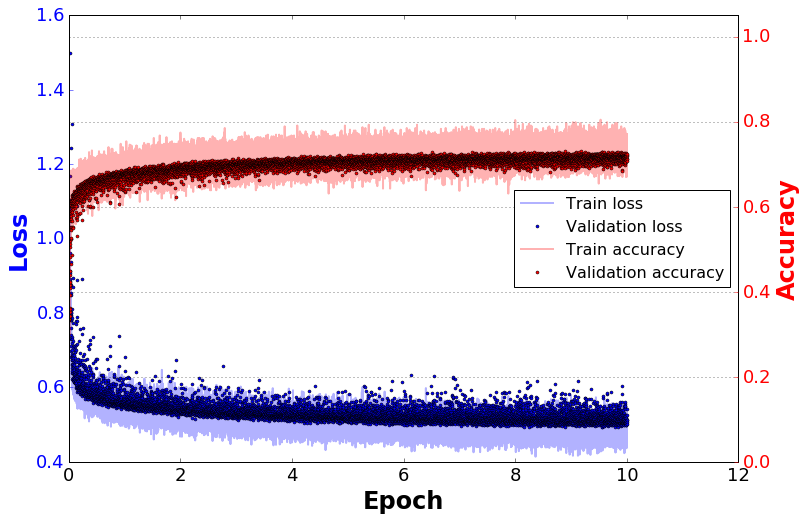

In [27]:
plot_utils.disp_learn_hist(loc)

In [28]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def disp_learn_hist_smoothed(location, losslim=None, window_train=400,window_val=40,show=True):
    train_log=location+'/log_train.csv'
    val_log=location+'/log_val.csv'
    
    train_log_csv = pd.read_csv(train_log)
    val_log_csv  = pd.read_csv(val_log)

    epoch_train    = moving_average(np.array(train_log_csv.epoch),window_train)
    accuracy_train = moving_average(np.array(train_log_csv.accuracy),window_train)
    loss_train     = moving_average(np.array(train_log_csv.loss),window_train)
    
    epoch_val    = moving_average(np.array(val_log_csv.epoch),window_val)
    accuracy_val = moving_average(np.array(val_log_csv.accuracy),window_val)
    loss_val     = moving_average(np.array(val_log_csv.loss),window_val)

    epoch_val_uns    = np.array(val_log_csv.epoch)
    accuracy_val_uns = np.array(val_log_csv.accuracy)
    loss_val_uns     = np.array(val_log_csv.loss)

    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    line11 = ax1.plot(epoch_train, loss_train, linewidth=2, label='Average training loss', color='b', alpha=0.3)
    line12 = ax1.plot(epoch_val, loss_val, label='Average validation loss', color='blue')

    ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)
    if losslim is not None:
        ax1.set_ylim(0.,losslim)
    
    ax2 = ax1.twinx()
    line21 = ax2.plot(epoch_train, accuracy_train, linewidth=2, label='Average training accuracy', color='r', alpha=0.3)
    line22 = ax2.plot(epoch_val, accuracy_val, label='Average validation accuracy', color='red')    
    
    ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,1.0)

    lines  = line11+ line12+ line21+ line22

    labels = [l.get_label() for l in lines]
    
    leg    = ax2.legend(lines, labels, fontsize=16, loc=5, numpoints=1)
    leg_frame = leg.get_frame()
    leg_frame.set_facecolor('white')

    if show:
        plt.grid()
        plt.show()
        return

    return fig

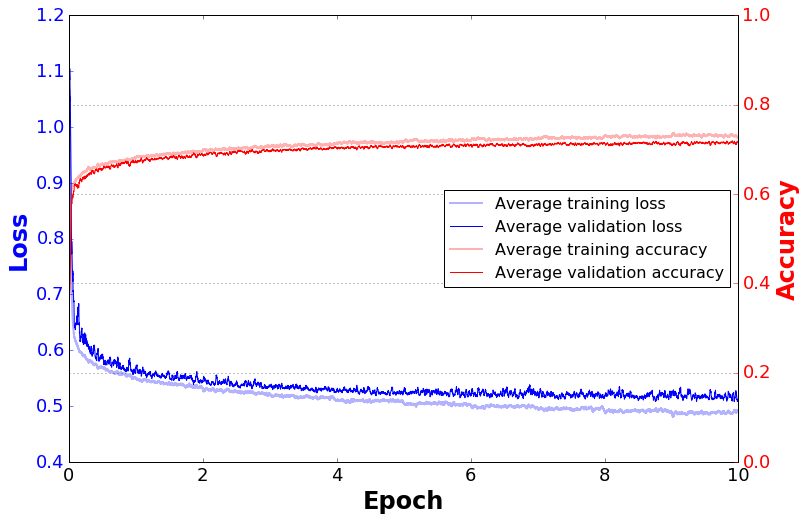

In [29]:
disp_learn_hist_smoothed(loc,window_train=200,window_val=20)

## Map Flagged FiTQun Events to ResNet Events

In [53]:
resnet_files = np.load(loc + "/test_validation_iteration_dump.npz",allow_pickle=True)

In [113]:
rn_labels = np.array(resnet_files['labels'].flatten())
rn_predictions = np.array(resnet_files['predicted_labels'].flatten())
rn_energies = np.array(resnet_files['energies'].flatten())
rn_softmaxes = np.array(resnet_files['softmax'].reshape(-1,3))
rn_event_ids = np.array(resnet_files['eventids'].flatten())
rn_root_files = np.array(resnet_files['rootfiles'].flatten())

In [3]:
dset_location = '/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5'
indices_loc = '/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz'
dset = h5py.File(dset_location,'r')

In [4]:
fq_e = np.load('/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz', allow_pickle=True)
fq_m = np.load('/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz',allow_pickle=True)
fq_g = np.load('/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz',allow_pickle=True)
ind = np.load(indices_loc,allow_pickle=True)

In [7]:
ind['test_idxs'].shape

(3351020,)

### Filter out flagged FiTQun Results
I only care about getting the eventid's and filenames for now, since I'm not dealing with the FiTQun results themselves.

In [148]:
e_flag = (fq_e['flag'])
m_flag = (fq_m['flag'])
g_flag = (fq_g['flag'])
flagged_indices_e = np.where((e_flag[:,0]==1)|(e_flag[:,1]==1))
flagged_indices_m = np.where((m_flag[:,0]==1)|(m_flag[:,1]==1))
flagged_indices_g = np.where((g_flag[:,0]==1)|(g_flag[:,1]==1))
fq_e_flagged_files = fq_e['filename'][flagged_indices_e]
fq_m_flagged_files = fq_m['filename'][flagged_indices_m]
fq_g_flagged_files = fq_g['filename'][flagged_indices_g]
fq_e_flagged_ids = fq_e['eventid'][flagged_indices_e]
fq_m_flagged_ids = fq_m['eventid'][flagged_indices_m]
fq_g_flagged_ids = fq_g['eventid'][flagged_indices_g]

In [149]:
fq_files = np.concatenate((fq_e_flagged_files, fq_m_flagged_files, fq_g_flagged_files))
fq_ids = np.concatenate((fq_e_flagged_ids, fq_m_flagged_ids, fq_g_flagged_ids))

In [150]:
fq_flagged_origin_info = list([i for i in zip(fq_files,fq_ids)])

In [151]:
len(fq_flagged_origin_info)/(len(e_flag)+len(m_flag)+len(g_flag))

0.2193331384406174

Which is about the fraction we anticipated.

In [97]:
rn_origin_info = list([i for i in zip(rn_root_files,rn_event_ids)])

In [114]:
rn_output= list([i for i in zip(rn_origin_info, rn_labels,rn_predictions,rn_energies,rn_softmaxes)])

In [118]:
rn_output[62]

(('/project/rpp-tanaka-ab/machine_learning/data/IWCDmPMT_4pi_full_tank/WCSim/e-/E0to1000MeV/unif-pos-R371-y521cm/4pi-dir/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_431.root',
  743.0),
 1,
 1,
 820.16205,
 array([4.3608493e-01, 5.6389272e-01, 2.2395963e-05], dtype=float32))

In [119]:
rn_origin_idx_dic = {}
for i in range(len(d)):
    rn_origin_idx_dic[rn_output[i][0]] = i

In [120]:
len(rn_origin_idx_dic.keys())

262144

In [128]:
from collections import Counter

In [134]:
len(Counter(rn_origin_info).keys())

262144